# Import Modules

In [3]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import *
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# import basic plot tools
from qiskit.visualization import plot_histogram

# Import IBM account

In [12]:
# import IBM account
from qiskit import IBMQ
#IBMQ.save_account('778b98c9541382feaf24808bf49db5311d9382052a420c94e274021cdd7e051c104eb5730ad637c0f29cacb8ff0b6067164fa80fc4ad5427f79ca97bfa42c714')
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
for backend in provider.backends():
    print(backend)

configrc.store_credentials:WARNING:2023-11-23 12:11:28,593: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-11-23 12:11:28,842: Credentials are already in use. The existing account in the session will be replaced.


ibmq_qasm_simulator
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibm_lagos
ibm_nairobi
ibm_perth
ibm_brisbane


# Implement your Quantum Circuit (QC)

In [4]:
n=3
def dj_oracle(case, n):
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        b = np.random.randint(1,2**n)
        b_str = format(b, '0'+str(n)+'b')
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [5]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [6]:
n = 3
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

┌───┐     ┌─────────┐┌───┐┌─┐      
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├──────
     ├───┤     │         │├───┤└╥┘┌─┐   
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├───
     ├───┤     │  Oracle │├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─────┤2        ├┤ H ├─╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├┤3        ├──────╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║ 
c: 3/═══════════════════════════╩══╩══╩═
                                0  1  2

# Set up backend and run you QC on Qasm simulator and real devices

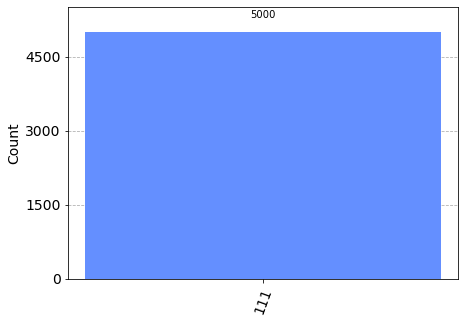

In [34]:

backend=Aer.get_backend('qasm_simulator')
#device_backend = provider.get_backend('ibm_nairobi')

# transpile the circuit # 0: no optimization
                        # 1: light optimization
                        # 2: heavy optimization
                        # 3: even heavier optimization
transpiled_dj_circuit = transpile(dj_circuit, backend=backend, optimization_level=3)

# run the circuit on the selected backend
job = backend.run(transpiled_dj_circuit, shots=10000)


# get the results
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

# Implement Noise Model

In [23]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeNairobi
from qiskit_aer import AerSimulator

In [24]:
# Build noise model from backend properties
backend = FakeLima()
noise_model = NoiseModel.from_backend(backend)

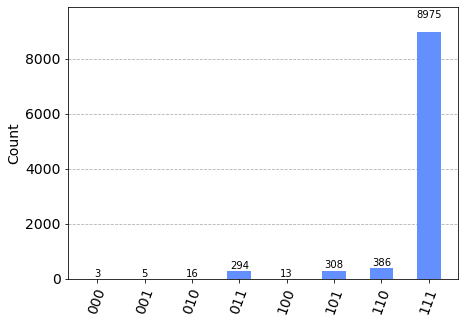

In [32]:
# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model)
transpiled_circuit = transpile(dj_circuit, backend,initial_layout=None, optimization_level=3)
result = backend.run(transpiled_circuit, shots=10000).result()

counts = result.get_counts()
plot_histogram(counts)

# Real mimic of the Fake Backend

In [36]:
# Package for querying the IBM Quantum API
import requests
import numpy as np
import seaborn as sns

# Load all the basic Qiskit functionality
from qiskit import *
# Get the properties and configuarition classes used to define the data for a Qiskit backend
from qiskit.providers.models import BackendProperties, QasmBackendConfiguration
# The 'fake' Qiskit backend class
from qiskit.providers.fake_provider import FakeBackend

# Plotting routines
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
try:
    plt.style.use('quantum-light')
except:
    pass

In [45]:
props_res = requests.get('https://api-qcon.quantum-computing.ibm.com/api/Backends/ibm_nairobi/properties')
if not props_res.json().get('backend_name', None): raise Exception('Request failed')

In [46]:
props = BackendProperties.from_dict(props_res.json())

In [47]:
def fake_backend_from_properties(props):
    """Return a FakeBackend from a BackendProperties object
    
    Parameters:
        props (BackendProperties): A backend properties instance
        
    Returns:
        FakeBackend: A fake backend matching the given properties data
        
    Raises:
        ValueError: Could not determine the two-qubit basis gate type
    """
    # Generate the set of basis gates from the gate info in the properties
    basis_gates = set()
    for gate in props.gates:
        basis_gates.add(gate.gate)
    basis_gates = list(basis_gates)
    
    # Determine the two-qubit entangling gate used to generate the coupling map
    two_qubit_gate = None
    if 'cx' in basis_gates:
        two_qubit_gate = 'cx'
    elif 'ecr' in basis_gates:
        two_qubit_gate = 'ecr'
    elif 'cz' in basis_gates:
        two_qubit_gate = 'cz'
    else:
        raise ValueError('I do not know what 2Q gate the backend is using')
    # Iterate over the two-qubit gates to obtain the coupling map
    coupling_map = []
    for gate in props.gates:
        if gate.gate == two_qubit_gate:
            coupling_map.append(gate.qubits)
    # Form a configuration object from the data in the properties
    config = QasmBackendConfiguration(backend_name=props.backend_name,
                                      backend_version=props.backend_version,
                                      n_qubits=len(props.qubits),
                                      basis_gates=basis_gates,
                                      gates=basis_gates, # This is not really valid, but not using it
                                      local=True,
                                      simulator=False,
                                      conditional=True,
                                      open_pulse=False,
                                      memory=True,
                                      max_shots=10000,
                                      coupling_map=coupling_map)

    # Overload the properties method on the FakeBackend to return our properties
    def properties():
        return props

    # Form the actual FakeBackend to return 
    fake_backend = FakeBackend(config)
    fake_backend.properties = properties

    return fake_backend

In [48]:
fake_backend = fake_backend_from_properties(props)

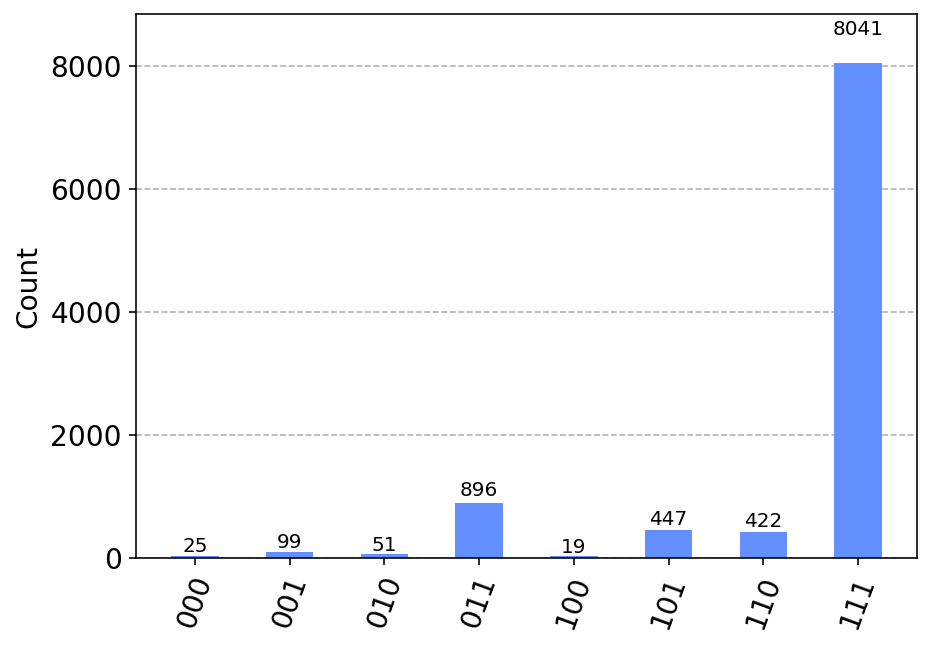

In [49]:
transpiled_dj_circuit = transpile(dj_circuit, backend=fake_backend, optimization_level=3)

# run the circuit on the selected backend
job = fake_backend.run(transpiled_dj_circuit, shots=10000)


# get the results
results = job.result()
answer = results.get_counts()

plot_histogram(answer)